<a href="https://colab.research.google.com/github/SchapiroLabor/CellLensBenchmark/blob/main/cHL_CODEX_LITE_CellLENS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CellLENS (LITE version):

# Analysis on Murine-spleen CODEX Data without morphology images

In this tutorial, we provide a lite version analysis of CellLENS pipeline on Murine-spleen date, including the generation of graphs and training of LENS GNN duo model. Please refere to Tutorial II for the full version of CellLENS (with morphology training).

## Step 0: Load packages

In [1]:
!pip install celllens==0.1.0

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00

In [6]:
#import warnings
#warnings.filterwarnings("ignore", category=UserWarning)
#import sys
#sys.path.append("../src/")
##

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import skimage
import sys

from celllens.utils import *
import os
from tqdm import tqdm
from skimage.io import imread
from celllens.preprocessing import *
from celllens.datasets import *
from celllens.celllens import *
import seaborn as sns
import torch

## packages for loading dataset deposited on Zenodo
import requests
import tifffile as tiff
import io

## for clearity
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

## to upload files to colab
from google.colab import files

In [3]:
## since in this CellLENS version we will use GPU (thus cuda), we can also run it on google colab

## if running on google colab etc
if 'google.colab' in str(get_ipython()):
  RUN_COLAB = True
else:
  RUN_COLAB = False

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Step I: Read in the data

Read in cHL_CODEX quantification table \
Upload file through file explorer

In [8]:
df = pd.read_csv('cHL_CODEX_cleaned.csv')

In [ ]:
#to upload files, throws error
#uploaded = files.upload()
#df = pd.read_csv(io.BytesIO(uploaded['my_data.csv']))

We first load the codex murine dataset

In [10]:
# we have deposited the tutorial data onto zenodo for convinient loading
df_url = 'https://zenodo.org/records/14629754/files/features_and_metadata.csv?download=1'

dfmurine = pd.read_csv(df_url, index_col = 0)

Here in the tutorial we provided an example dataset (CODEX murine spleen data, from Goltsev et al, Cell, 2018).

The columns should be self explainable - with protein **feature expression profiles**, and some related meta data, including **cell locations** etc

In [19]:
dfmurine
#in this tutorial data we have 50k cells

,cellLabelInImage,cellSize,CD45,Ly6C,TCR,Ly6G,CD19,CD169,CD106,CD3,...,CD35,CD2135,CD44,nucl,NKp46,cluster.term,centroid_x,centroid_y,field_of_view,cluster.termV2
0,3,283,0.000000,316.262419,595.768897,49.077602,608.994748,322.609557,0.000000,163.539961,...,217.914412,69.250551,0.000000,9100.068826,572.555576,Other,7.717314,240.809187,1,Vessel
1,7,215,0.000000,0.000000,134.472467,0.000000,1431.469046,73.665657,0.000000,0.000000,...,1135.190597,96.309696,0.000000,15071.640580,0.000000,B,5.916279,1334.600000,1,Other
2,11,397,0.000000,372.035233,899.713809,261.276071,605.481258,1023.287300,1152.344425,807.322092,...,488.606413,245.895189,236.229915,16381.046110,769.252953,Other,9.277078,1167.989924,1,Vessel
3,13,500,2966.989105,337.537437,329.896108,37.743424,671.873764,51.828695,49.372156,0.000000,...,0.000000,0.000000,942.795851,2283.347509,312.484433,B,11.430000,1026.952000,1,B
4,15,838,3797.157518,665.627685,1938.002387,368.658711,2616.937947,1682.991647,3003.585919,2089.879475,...,1822.097852,392.223150,5141.479714,23181.488070,575.791170,Mph,10.233890,656.547733,1,Mph
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53495,220,878,2010.562000,529.468500,0.000000,748.099900,1797.500000,2005.353000,5074.064000,2018.746000,...,1378.769000,555.147900,2139.469000,6670.871000,840.025000,Mph,8856.712984,8078.510251,63,Mph
53496,221,947,3151.869000,720.791600,566.963800,534.545700,724.435200,1801.644000,1195.907000,1694.527000,...,778.746000,373.721000,1152.291000,2721.070000,9540.707000,NK,8874.391763,8164.459345,63,NK
53497,223,1827,7266.125000,1077.432000,5073.809000,823.874500,1511.285000,2339.300000,3403.034000,2614.637000,...,1329.873000,688.305400,2439.289000,16289.960000,9927.915000,NK,8883.950739,8099.090312,63,NK
53498,225,1469,3815.305000,863.790400,648.502300,695.037400,978.518100,2769.580000,1735.379000,2416.990000,...,820.447300,483.748100,1724.066000,1054.221000,8091.533000,Other,8965.542546,8106.320626,63,NK


In [9]:
df#.head()
# we have 140k cells

,BCL.2,CCR6,CD11b,CD11c,CD15,CD16,CD162,CD163,CD2,CD20,...,TCRb,Tim.3,VISA,Vimentin,a.SMA,b.Catenin,cellSize,x,y,cell_type
0,0.792642,0.617038,0.000089,0.000040,0.000029,0.097688,0.007772,0.005356,0.159593,0.754060,...,0.159092,0.006533,0.000454,0.139826,0.0,0.057827,42,75,2,B
1,0.000000,0.127394,0.062173,0.660572,0.000000,0.000000,0.172885,0.006180,0.000000,0.000000,...,0.058234,0.111610,0.182849,0.899717,0.0,0.267198,63,1767,2,DC
2,0.060620,0.134818,0.298522,0.083348,0.000000,0.182152,0.000210,0.001401,0.000000,0.000000,...,0.000000,0.004900,0.454174,0.069180,0.0,0.104686,29,2545,2,NK
3,0.000000,0.012896,0.287698,0.268121,0.000000,0.124361,0.016805,0.208045,0.037673,0.000019,...,0.052230,0.148087,0.228221,0.053541,1.0,0.283151,64,2899,3,Monocyte
4,0.201057,0.110590,0.000000,0.000000,0.000000,0.000000,0.745316,0.013513,0.292691,0.039192,...,0.597647,0.013284,0.000454,0.234038,0.0,0.000000,61,3657,3,CD4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145156,0.000000,0.523642,1.000000,0.182044,1.000000,1.000000,0.055458,0.019692,0.004761,0.064028,...,0.067239,0.082646,0.671506,0.455424,0.0,0.040877,119,2882,8004,Neutrophil
145157,0.000000,0.210238,0.313372,0.076860,0.986128,0.587575,0.044324,0.053227,0.099109,0.090999,...,0.069040,0.077637,0.327586,1.000000,0.0,0.068794,82,2893,8004,Neutrophil
145158,0.000000,0.620555,0.000089,0.025792,0.000029,0.255168,0.000000,0.000000,0.829552,0.068726,...,0.806268,0.250223,1.000000,0.462049,0.0,0.086740,92,2327,8004,Other
145159,0.000000,0.597890,0.000000,0.099606,0.000029,0.370193,0.012604,0.032381,0.571802,1.000000,...,0.362010,0.142534,0.086661,0.963140,0.0,0.167498,184,3371,8003,CD4


We can check the location of cells on a random point on the tissue:

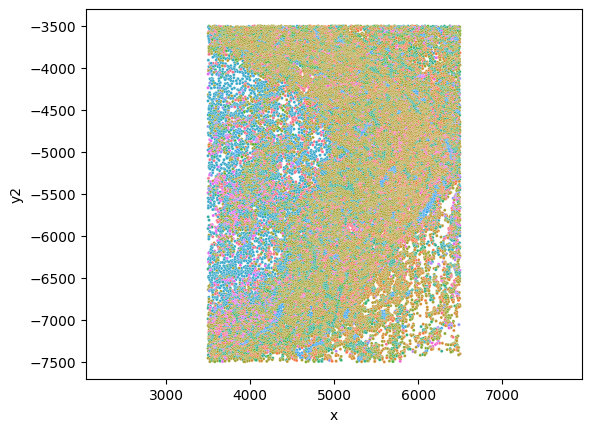

In [13]:
df['y2'] = -1 * df['y'] # this is just for seaborn plotting reverse y axis

temp = df.loc[(df.x > 3500) & (df.x < 6500) &
              (df.y > 3500) & (df.y < 7500), :]

sns.scatterplot(data = temp, x = 'x', y = 'y2', hue = 'cell_type', s=5, legend=False)
plt.axis('equal')  # Ensures equal scaling for x and y axes
plt.show()

#### when doing seperate FOVs

This example is an stiched iamges of an entire scan. In some senarios its possible to seperate FOVs (like TMAs).

In that case (if the images were not already stiched) one could consider artificially stitching the images together (with space betweeen FOVs):

<img src="https://zenodo.org/records/14629754/files/git-1.png?download=1" alt="Image Description" width="300">

You do need to update the x y locations in the df accordingly after this.

## Step II: Initialize the object

In [14]:
df.columns

Index(['BCL.2', 'CCR6', 'CD11b', 'CD11c', 'CD15', 'CD16', 'CD162', 'CD163',
       'CD2', 'CD20', 'CD206', 'CD25', 'CD30', 'CD31', 'CD4', 'CD44', 'CD45RA',
       'CD45RO', 'CD45', 'CD5', 'CD56', 'CD57', 'CD68', 'CD69', 'CD7', 'CD8',
       'Collagen.4', 'Cytokeratin', 'DAPI.01', 'EGFR', 'FoxP3', 'Granzyme.B',
       'HLA.DR', 'IDO.1', 'LAG.3', 'MCT', 'MMP.9', 'MUC.1', 'PD.1', 'PD.L1',
       'Podoplanin', 'T.bet', 'TCR.g.d', 'TCRb', 'Tim.3', 'VISA', 'Vimentin',
       'a.SMA', 'b.Catenin', 'cellSize', 'x', 'y', 'cell_type', 'y2'],
      dtype='object')

In [15]:
## these are the expression profile (proteins)

features_list = [
    'BCL.2', 'CCR6', 'CD11b', 'CD11c', 'CD15', 'CD16', 'CD162', 'CD163',
       'CD2', 'CD20', 'CD206', 'CD25', 'CD30', 'CD31', 'CD4', 'CD44', 'CD45RA',
       'CD45RO', 'CD45', 'CD5', 'CD56', 'CD57', 'CD68', 'CD69', 'CD7', 'CD8',
       'Collagen.4', 'Cytokeratin', 'DAPI.01', 'EGFR', 'FoxP3', 'Granzyme.B',
       'HLA.DR', 'IDO.1', 'LAG.3', 'MCT', 'MMP.9', 'MUC.1', 'PD.1', 'PD.L1',
       'Podoplanin', 'T.bet', 'TCR.g.d', 'TCRb', 'Tim.3', 'VISA', 'Vimentin',
       'a.SMA', 'b.Catenin'
]


Then we can first initialize the object

In [16]:
# optionally, clean data Nans - in case data have fault
df.fillna(0, inplace=True)

murine_dataset = LENS_Dataset(df,
                              features_list=features_list,
                              nbhd_composition=15,
                              feature_neighbor=15,
                              spatial_neighbor=15,
                              path2img='./processed_images/', # Not used - location to store cropped images
                             use_transform = False) # Not used -  processed image saving location - in later steps

In [17]:
import warnings
warnings.filterwarnings('ignore')

murine_dataset.initialize(cent_x="x", # x loc of cells
                          cent_y="y", # y loc of cells
                          celltype="feature_labels", # default option - run leiden to initialize the clusters
                          pca_components=25, # PCA components to use, user decide
                          cluster_res=0.5) # leiden initialization resolution

Leiden clustering identified 17 clusters as input population identity.
Calculating cell neighborhood composition matrix...
Constructing the graph...
Done!


Initialization finished. ```cluster_res = 0.5``` generated 15 clusters for neighborhood composition estimation.

Alternatively, the user could choose to use parameter ```n_clusters``` to directly set the desired cluster number.

Note we only need a coarse estimation of neighborhood composition, so we suggest the number stay on the slightly lower side (compared to actual expected populations).

Most of the time ```cluster_res = 0.5``` would work great, but in some cases (depends on the data) it would generate significantly lower cluster numbers than expected (e.g. 5 clusters but you are expecting 10-15 clusters of coarse/basic cell types). In that case you should intervene.

In [20]:
# check the training label
murine_dataset.dual_labels.shape # should be cluster number x 2

(145161, 34)

We dont want to save to our drive

In [ ]:
# in case using colab
#if RUN_COLAB:
#  from google.colab import drive
#  drive.mount('/content/drive')

## Step II: Train CellLENS without Morphology

There are two steps for training CellLENS:

1. (Skipped - becaues no morphology information in this case) Train LENS CNN to get CNN embedding
2. Train LENS GNN duo to get GNN embedding

To srat the CellLENS object here, we will set ```cnn_model = 'LITE'```.

Start the object

In [21]:
#making sure notebook recognizes GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
murine_celllens = CellLENS(murine_dataset,
                           device,
                           cnn_model= None, ### NOTE here set to no cnn model
                           cnn_latent_dim=128,
                           gnn_latent_dim=32
                          ) # generally these parameters no need to change ,
                           #input_channel_num=2 # this case the images have two channels, nuclear and membrane, thus 2

In [23]:
murine_celllens

### Train LENS GNN

In [ ]:
murine_celllens.get_lens_embedding(round=5, #took 103 minutes
                                   k=32,
                                   learning_rate=1e-3,
                                   n_epochs=5000,
                                   loss_fn='MSELoss',
                                   OptimizerAlg='Adam',
                                   optimizer_kwargs={},
                                   SchedulerAlg=None,
                                   scheduler_kwargs={},
                                   verbose=True) # generally these parameters do not need to change

The GNN training part should be relatively fast. We train a total of 5 repeated times. The total time should be ~ 10 mins for this dataset.

The memory usage here is dependent on cell numbers, which the GPU need to store the cell graph. The memory usage on 50k cells is ~ 7GB.

## Step III: LENS Clustering & Visualization

In [ ]:
# the resulting CellLENS embedding is stored here:
pd.DataFrame(murine_celllens.lens_embedding)

In [ ]:
embedding = pd.DataFrame(murine_celllens.lens_embedding)

In [ ]:
embedding.to_csv('celllens_embedding.csv', index=False)

In [ ]:
files.download('elllens_embedding.csv')

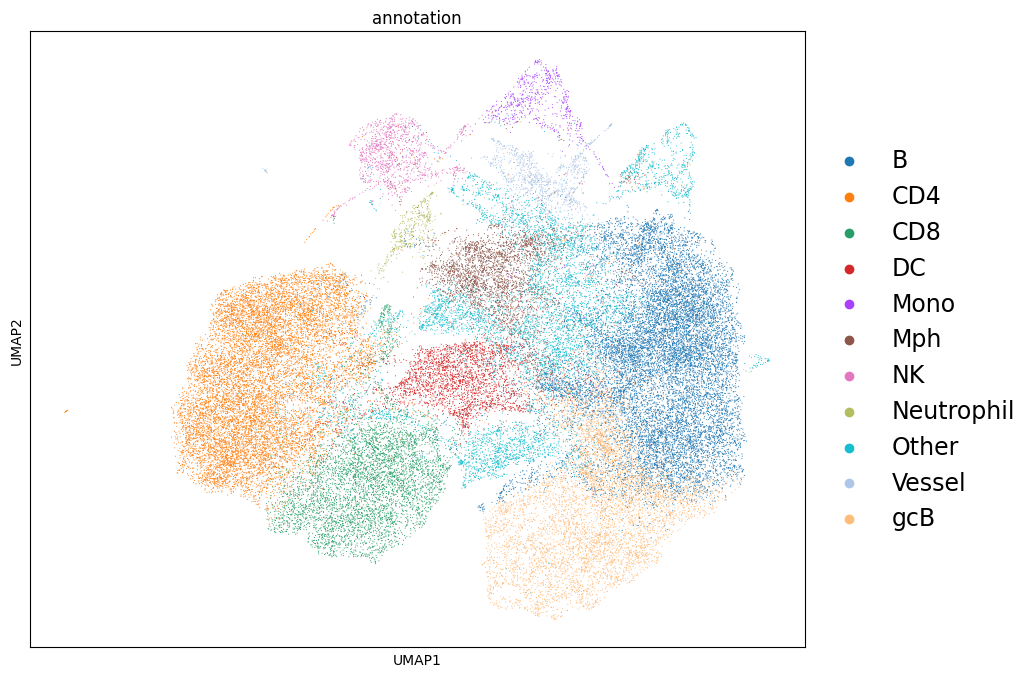

In [ ]:
# we also have a wrapper function for quick UMAP visualization of the CellLENS embedding
murine_celllens.visualize_umap(murine_celllens.lens_embedding, murine_dataset.df['cell_type']) # here coloring with original cell lables

With the CellLENS embedding available, we can perform clustering and identify different cell populations.

We provide a function for Leiden clustering in our package for convinient usage.



In [ ]:
murine_celllens.get_lens_clustering(neighbor=15, # standard leiden parameter
                                    resolution=1.0, # resolution for leiden - specific
                                    entropy_threshold=0.75, # CellLENS parameter - generally no change needed
                                    concen_threshold=1, # CellLENS parameter - generally no change needed
                                    max_breaks=3, # CellLENS parameter - generally no change needed
                                    size_lim=50 # CellLENS parameter - smallest cluster size allowed
                                   )

And then we can visualize the results on the UMAP.

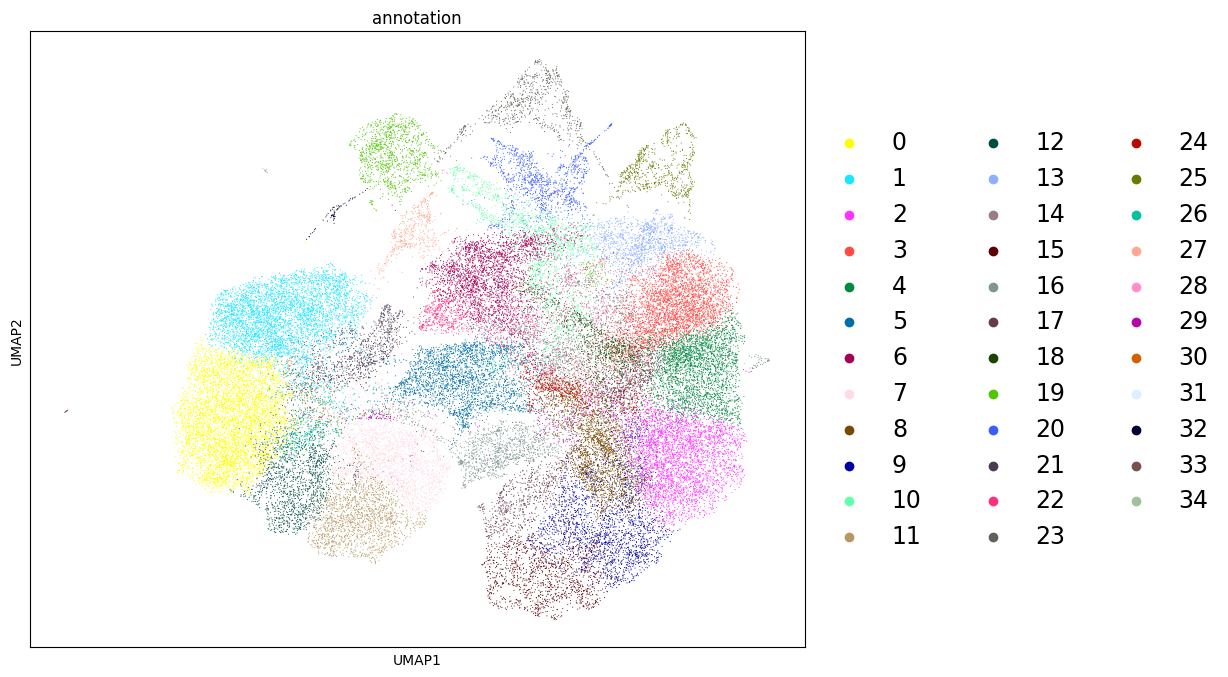

In [ ]:
murine_celllens.visualize_umap(murine_celllens.lens_embedding, murine_celllens.lens_clustering)

In [ ]:
# the clustering results can also be easily accessed here
murine_celllens.lens_clustering

['20',
 '22',
 '20',
 '3',
 '6',
 '6',
 '6',
 '20',
 '18',
 '21',
 '27',
 '6',
 '3',
 '18',
 '6',
 '22',
 '24',
 '5',
 '5',
 '21',
 '14',
 '24',
 '23',
 '6',
 '12',
 '21',
 '24',
 '22',
 '0',
 '5',
 '18',
 '21',
 '20',
 '19',
 '34',
 '7',
 '7',
 '25',
 '6',
 '20',
 '13',
 '6',
 '13',
 '27',
 '3',
 '3',
 '3',
 '6',
 '20',
 '6',
 '25',
 '6',
 '6',
 '6',
 '3',
 '19',
 '3',
 '6',
 '6',
 '28',
 '6',
 '5',
 '6',
 '21',
 '3',
 '24',
 '10',
 '6',
 '13',
 '6',
 '27',
 '6',
 '18',
 '3',
 '3',
 '10',
 '4',
 '10',
 '20',
 '22',
 '25',
 '22',
 '3',
 '6',
 '21',
 '14',
 '10',
 '0',
 '25',
 '21',
 '28',
 '10',
 '6',
 '10',
 '6',
 '24',
 '20',
 '25',
 '3',
 '7',
 '2',
 '6',
 '5',
 '5',
 '6',
 '27',
 '27',
 '14',
 '6',
 '11',
 '6',
 '3',
 '6',
 '24',
 '20',
 '4',
 '24',
 '18',
 '5',
 '6',
 '5',
 '1',
 '5',
 '3',
 '13',
 '22',
 '3',
 '0',
 '20',
 '20',
 '5',
 '20',
 '11',
 '10',
 '6',
 '30',
 '20',
 '20',
 '24',
 '13',
 '10',
 '23',
 '21',
 '1',
 '21',
 '14',
 '6',
 '18',
 '20',
 '18',
 '7',
 '13',
 '20

One could easily save this result out and perform your various downstream analysis.